# Análise da temperatura média e poluentes



|Dados||Desc|
|---||----|
|$CO$||Monóxido de carbono|
|$O_3$||Ozônio|
|$NO_2$||Dióxido de nitrogênio|
|$SO_2$||Dióxido de enxofre|
|PM2.5||Partículas inaláveis|

- a justificativa é algo que eu fiz no trabalho? Eu preciso "atingir" ela?

## Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import randint
from datetime import datetime, date, timedelta

from sklearn.model_selection import GridSearchCV
#from sklearn.model_selection import GroupKFold, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import Normalizer
# from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
#from sklearn.model_selection import StratifiedShuffleSplit
from fast_ml.model_development import train_valid_test_split

from sklearn.metrics import mean_squared_error
#from sklearn.metrics import silhouette_score
#from sklearn.metrics import davies_bouldin_score
#from sklearn.metrics import calinski_harabasz_score
from sklearn.model_selection import cross_validate
# from sklearn.pipeline import Pipeline

SEED = 101
np.random.seed(SEED)

## Importação da base de dados

link: https://queimadas.dgi.inpe.br/queimadas/sisam/v2/dados/download/

In [2]:
dados_poluentes = pd.DataFrame()
pasta = "dados"
for diretorio, subpastas, arquivos in os.walk(pasta):
    for arquivo in arquivos:
        dados = pd.read_csv(f"{os.path.join(os.path.realpath(diretorio), arquivo)}")
        dados_poluentes = pd.concat([dados, dados_poluentes])
        
dados_poluentes.reset_index(drop=True, inplace = True)
dados_poluentes.head()

,datahora,co_ppb,no2_ppb,o3_ppb,pm25_ugm3,so2_ugm3,precipitacao_mmdia,temperatura_c,umidade_relativa_percentual,vento_direcao_grau,vento_velocidade_ms,focos_queimada,mun_geocod,mun_nome,mun_lat,mun_lon,mun_uf_nome
0,2011-01-01 00:00,108.9,1.5,10.0,7.5,0.8,0.0,25.7,74,222,1.9,NaN,4108304,FOZ DO IGUAÇU,-25.5401,-54.5858,PARANÁ
1,2011-01-02 00:00,111.4,1.0,13.2,8.3,0.6,20.0,22.6,93,189,1.1,1.0,4108304,FOZ DO IGUAÇU,-25.5401,-54.5858,PARANÁ
2,2011-01-03 00:00,139.3,1.3,8.1,10.0,0.7,0.0,23.6,86,131,1.1,NaN,4108304,FOZ DO IGUAÇU,-25.5401,-54.5858,PARANÁ
3,2011-01-04 00:00,126.4,0.9,12.7,7.1,0.5,35.0,23.1,90,130,0.9,NaN,4108304,FOZ DO IGUAÇU,-25.5401,-54.5858,PARANÁ
4,2011-01-05 00:00,155.6,1.4,6.0,6.0,0.7,0.0,26.2,76,123,0.9,NaN,4108304,FOZ DO IGUAÇU,-25.5401,-54.5858,PARANÁ


In [3]:
dados_poluentes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7305 entries, 0 to 7304
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datahora                     7305 non-null   object 
 1   co_ppb                       6575 non-null   float64
 2   no2_ppb                      6575 non-null   float64
 3   o3_ppb                       6575 non-null   float64
 4   pm25_ugm3                    6473 non-null   float64
 5   so2_ugm3                     6572 non-null   float64
 6   precipitacao_mmdia           2922 non-null   float64
 7   temperatura_c                7305 non-null   float64
 8   umidade_relativa_percentual  7305 non-null   int64  
 9   vento_direcao_grau           7305 non-null   int64  
 10  vento_velocidade_ms          7305 non-null   float64
 11  focos_queimada               8 non-null      float64
 12  mun_geocod                   7305 non-null   int64  
 13  mun_nome          

#### Seleciona do apenas as extrações do horário 00:00 (meia noite)

In [4]:
dados_poluentes = dados_poluentes.loc[dados_poluentes['datahora'].str.contains('00:00', case=False, regex=False, na=False)]

#### Mudando para datetime

In [5]:
dados_poluentes['datahora'] = pd.to_datetime(dados_poluentes['datahora'], format='%Y-%m-%d')

#### Dropando colunas

In [6]:
dados_poluentes = dados_poluentes.drop(columns=['focos_queimada', 'mun_uf_nome', 'mun_geocod', 'mun_lat', 'mun_lon', 'mun_nome'])

## Dados descritivos

In [7]:
dados_poluentes.describe()

,co_ppb,no2_ppb,o3_ppb,pm25_ugm3,so2_ugm3,precipitacao_mmdia,temperatura_c,umidade_relativa_percentual,vento_direcao_grau,vento_velocidade_ms
count,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,147.495072,1.243566,14.323238,10.989938,0.777105,4.539699,21.824812,82.294319,118.736140,2.323443
std,51.225034,0.562817,7.026899,6.643842,0.320207,11.500263,4.552533,12.828670,67.650014,0.803984
min,57.900000,0.200000,0.200000,0.000000,0.100000,0.000000,4.600000,38.000000,1.000000,0.200000
25%,114.100000,0.900000,9.200000,6.325000,0.600000,0.000000,19.400000,74.000000,61.000000,1.800000
50%,137.300000,1.100000,13.600000,9.500000,0.700000,0.000000,22.600000,85.000000,110.000000,2.200000
75%,168.900000,1.500000,18.700000,14.000000,1.000000,2.000000,25.175000,93.000000,164.000000,2.700000
max,543.200000,5.000000,47.800000,72.800000,3.000000,175.000000,31.300000,100.000000,359.000000,6.700000


## Análises gráficas

In [8]:
sns.set_style("ticks")

### Temperatura média ao decorrer dos anos

<AxesSubplot:xlabel='datahora', ylabel='temperatura_c'>

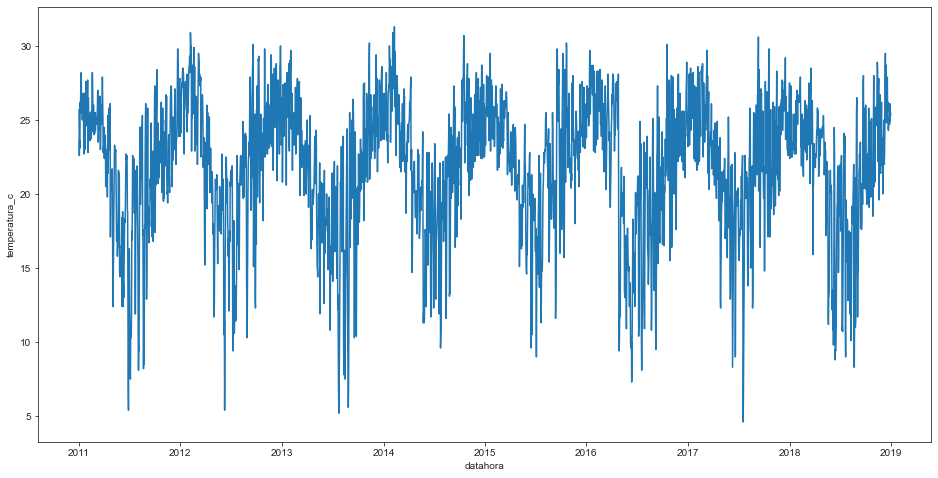

In [9]:
plt.figure(figsize=(16, 8))
sns.lineplot(x="datahora", y="temperatura_c", data = dados_poluentes)

##### Obs:

- No gráfico podemos notar a temperatura alta em determinados momentos, indicando a estação do ano mais quente, o verão.

### Temperatura média distribuição

<AxesSubplot:xlabel='temperatura_c', ylabel='Density'>

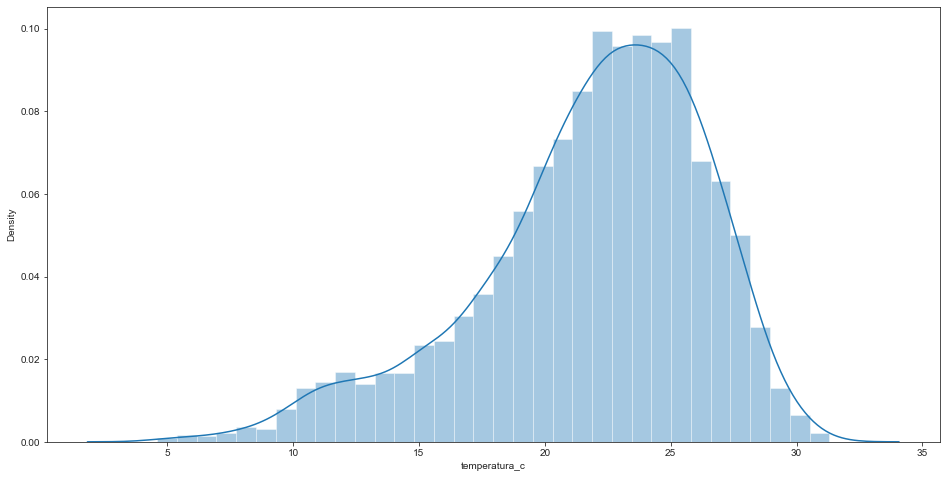

In [10]:
plt.figure(figsize=(16, 8))
sns.distplot(dados_poluentes["temperatura_c"])

- A curva dos dados de temperatura possui uma certa assimetria a esquerda, ou seja, a média é menor que a mediana e a moda

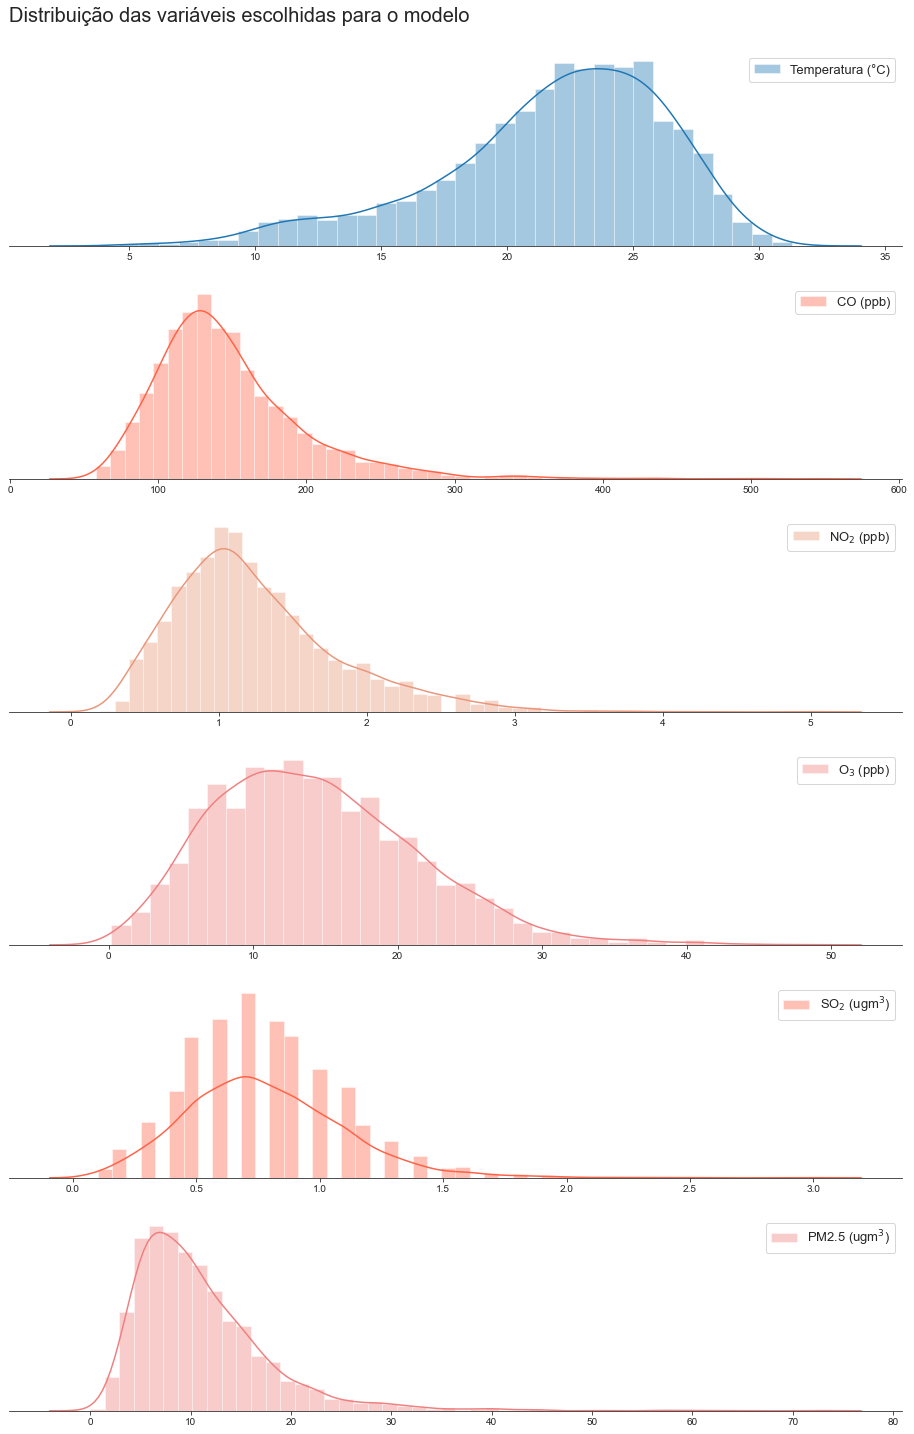

In [11]:
plt.figure(figsize=(16,25))

plt.subplot(6, 1, 1)
sns.distplot(dados_poluentes["temperatura_c"],  label = "Temperatura (°C)")
plt.xlabel("")
plt.ylabel("")
plt.yticks([])
plt.title("Distribuição das variáveis escolhidas para o modelo", loc="left", fontsize = 20, pad = 30)
plt.legend(fontsize=13)


plt.subplot(6, 1, 2)
sns.distplot(dados_poluentes["co_ppb"], label = "CO (ppb)", color="tomato")
plt.xlabel("")
plt.ylabel("")
plt.yticks([])
plt.legend(fontsize=13)

plt.subplot(6, 1, 3)
sns.distplot(dados_poluentes["no2_ppb"], label = "NO$_2$ (ppb)", color="darksalmon")
plt.xlabel("")
plt.ylabel("")
plt.yticks([])
plt.legend(fontsize=13)

plt.subplot(6, 1, 4)
sns.distplot(dados_poluentes["o3_ppb"], label = "O$_3$ (ppb)", color="lightcoral")
plt.xlabel("")
plt.ylabel("")
plt.yticks([])
plt.legend(fontsize=13)

plt.subplot(6, 1, 5)
sns.distplot(dados_poluentes["so2_ugm3"], label = "SO$_2$ (ugm$^3$)", color="tomato")
plt.xlabel("")
plt.ylabel("")
plt.yticks([])
plt.legend(fontsize=13)

plt.subplot(6, 1, 6)
sns.distplot(dados_poluentes["pm25_ugm3"], label = "PM2.5 (ugm$^3$)", color = "lightcoral")
plt.xlabel("")
plt.ylabel("")
plt.yticks([])
plt.legend(fontsize=13)

sns.despine(right=True, left=True, top=True)
plt.show()

In [12]:
dados_poluentes["temperatura_c"].mean()

21.824811772758373

In [13]:
dados_poluentes["temperatura_c"].median()

22.6

In [14]:
dados_poluentes["temperatura_c"].mode()[0]

22.6

### GEE ao decorrer dos anos

<AxesSubplot:xlabel='datahora', ylabel='co_ppb'>

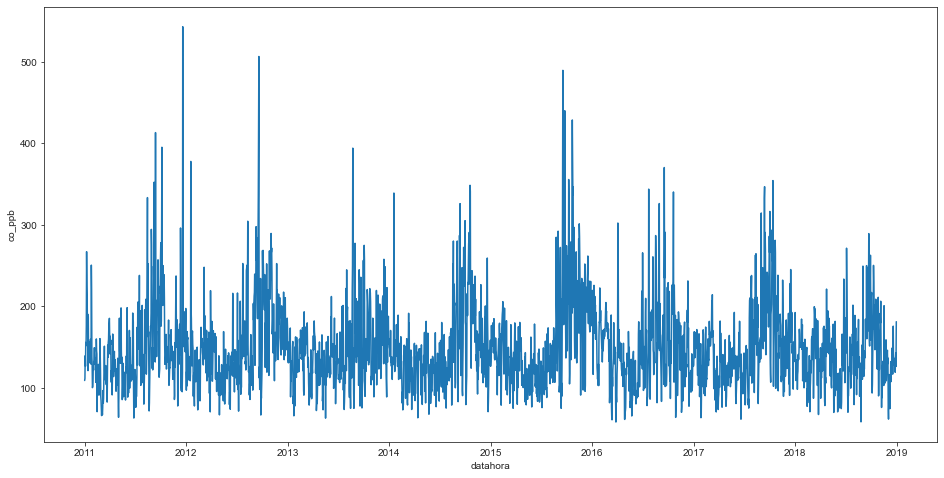

In [15]:
plt.figure(figsize=(16, 8))
sns.lineplot(x="datahora", y="co_ppb", data = dados_poluentes)

<AxesSubplot:xlabel='datahora', ylabel='o3_ppb'>

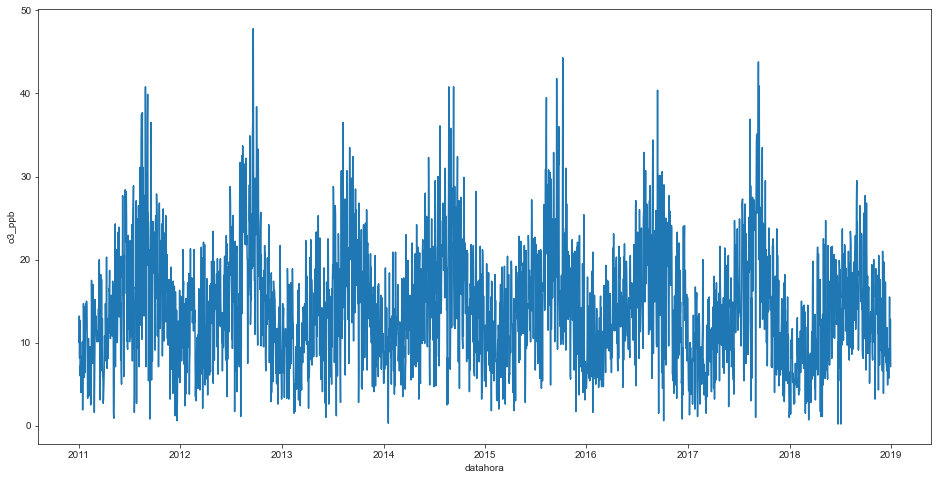

In [16]:
plt.figure(figsize=(16, 8))
sns.lineplot(x="datahora", y="o3_ppb", data = dados_poluentes)

##### Obs:

- Existe certos picos e eles diminuíram visualmente ao longo do anos.
- Os picos estão concentrados em perídos de transição entre primavera e verão.

<AxesSubplot:xlabel='datahora', ylabel='temperatura_c'>

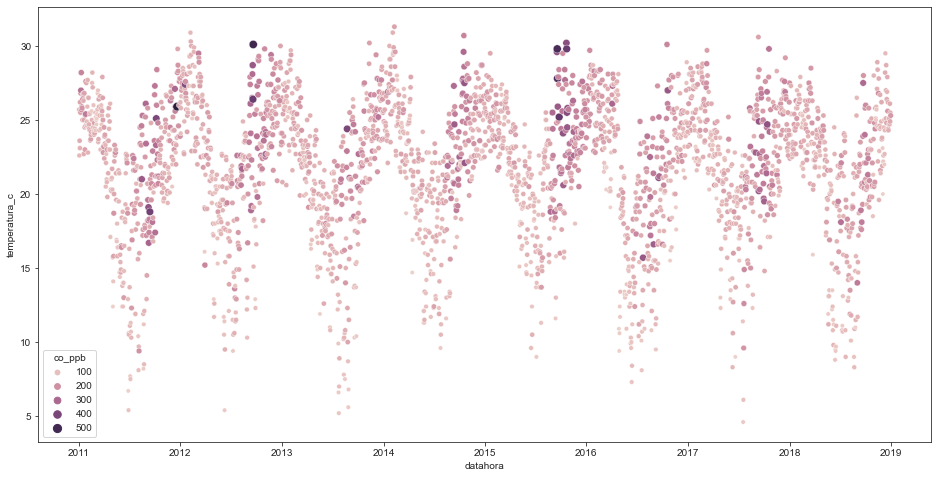

In [17]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x="datahora", y="temperatura_c", hue = "co_ppb", size = "co_ppb", data = dados_poluentes)

## Período de 2018

- Outono : De 21 de março a 21 de junho  
- Inverno: De 21 de junho a 23 de setembro  
- Primavera: De 23 de setembro a 21 de dezembro  
- Verão: De 21 de dezembro a 21 de março

<AxesSubplot:xlabel='datahora', ylabel='temperatura_c'>

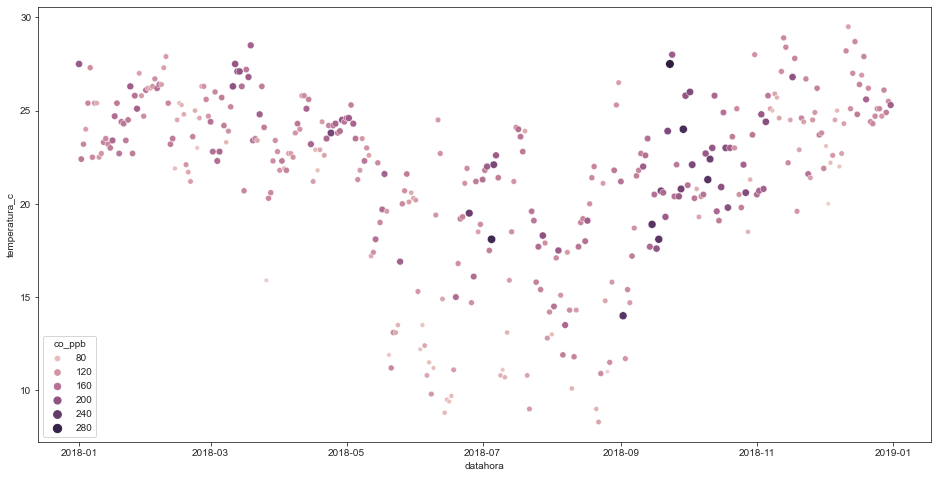

In [18]:
plt.figure(figsize=(16, 8))
sns.scatterplot(x="datahora", y="temperatura_c", hue = "co_ppb", size = "co_ppb", data = dados_poluentes.query("datahora.dt.year >= 2018"))

## Predição

### Eliminando outliers

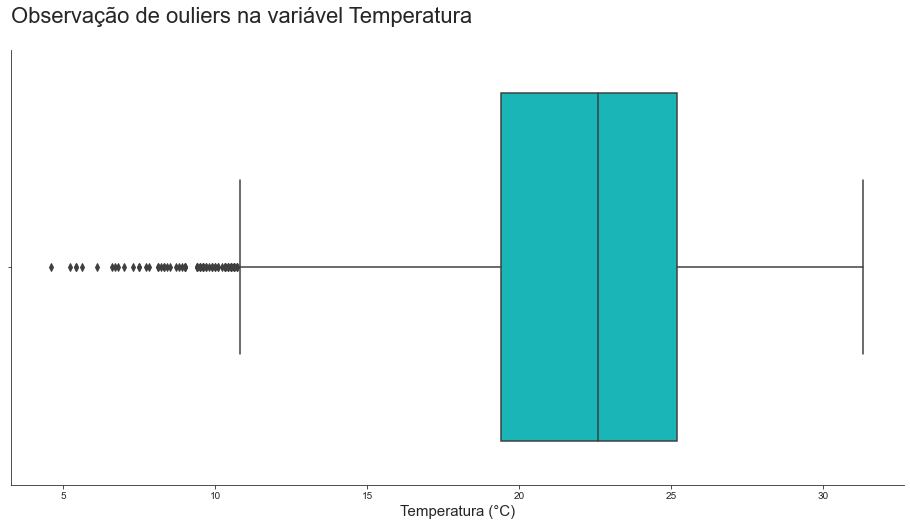

In [19]:
sns.set_style('ticks')
plt.figure(figsize = (16, 8))
palette = ['darkturquoise']
grafico = sns.boxplot(dados_poluentes['temperatura_c'], palette = palette)
grafico.set_title('Observação de ouliers na variável Temperatura', fontsize = 22, pad= 27, loc = 'left')
grafico.set_xlabel("Temperatura (°C)", fontsize = 15)
sns.despine()

#### Limitando valores da temperatura

- Limitando o valor da temperatura a um intervalo de 20 ao limite máximo, os outliers são totalmente removidos.

In [20]:
dados_poluentes = dados_poluentes.loc[~(dados_poluentes['temperatura_c'] < 20)]

In [21]:
dados_poluentes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2102 entries, 0 to 7301
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   datahora                     2102 non-null   datetime64[ns]
 1   co_ppb                       2102 non-null   float64       
 2   no2_ppb                      2102 non-null   float64       
 3   o3_ppb                       2102 non-null   float64       
 4   pm25_ugm3                    2102 non-null   float64       
 5   so2_ugm3                     2102 non-null   float64       
 6   precipitacao_mmdia           2102 non-null   float64       
 7   temperatura_c                2102 non-null   float64       
 8   umidade_relativa_percentual  2102 non-null   int64         
 9   vento_direcao_grau           2102 non-null   int64         
 10  vento_velocidade_ms          2102 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(2)


In [22]:
dados_poluentes.reset_index(inplace = True, drop = True)

## Teste com dados normais

In [23]:
correlacao = dados_poluentes[['co_ppb', 'no2_ppb', 'o3_ppb', 'pm25_ugm3', 'so2_ugm3', 'temperatura_c']].corr()

Text(0.0, 1.0, 'Correlação entre as variáveis escolhidas')

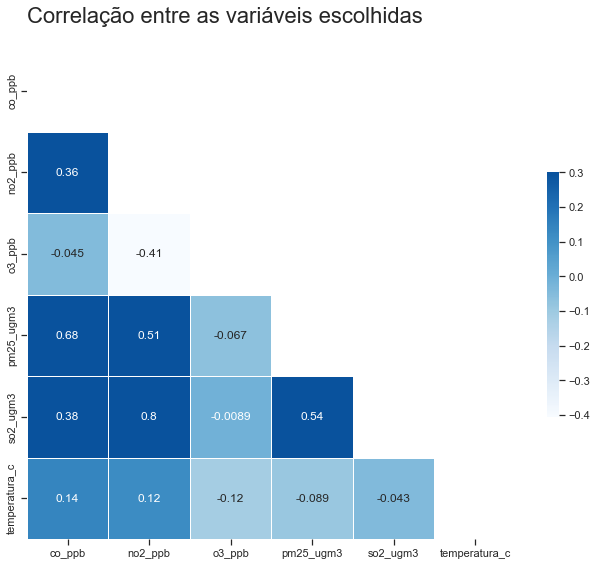

In [24]:
sns.set(style="ticks")

# Generate a mask for the upper triangle
mask = np.zeros_like(correlacao, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.color_palette("Blues", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlacao, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title("Correlação entre as variáveis escolhidas", fontsize = 22, pad= 27, loc = 'left')

In [25]:
dados_poluentes.columns

Index(['datahora', 'co_ppb', 'no2_ppb', 'o3_ppb', 'pm25_ugm3', 'so2_ugm3',
       'precipitacao_mmdia', 'temperatura_c', 'umidade_relativa_percentual',
       'vento_direcao_grau', 'vento_velocidade_ms'],
      dtype='object')

In [26]:
dados_normais_modelo = dados_poluentes[['co_ppb', 'no2_ppb', 'o3_ppb', 'pm25_ugm3', 'so2_ugm3', 'temperatura_c']]

### Dados de treino, validação e teste

Neste caso iremos treinar o modelo sem os dados de clima médios.

In [27]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(dados_normais_modelo, target = "temperatura_c",
                                                          train_size = 0.7, valid_size = 0.1,
                                                            test_size = 0.2, random_state = 101)

### Resultados classificador inocente

O dummy irá realizar uma predição base e o score dele irá gerar, consequentemente, uma base para avaliar o modelo. A estratégia está como "mean", ou seja, ele irá determinar o predict como a média e calculará o resultado do score com base nesse resultado.

In [28]:
classificador_dummy = DummyRegressor(strategy = 'mean')
classificador_dummy.fit(X_train, y_train)
print(f"Score - Dummy: {(classificador_dummy.score(X_test, y_test))*100:.2f}%")

Score - Dummy: -0.55%


### Modelo RandomForest Regressor

In [29]:
modelo_rf = RandomForestRegressor(n_estimators=100, random_state = SEED)
modelo_rf.fit(X_train, y_train)

previsoes = modelo_rf.predict(X_test)

print(f"Score: {(modelo_rf.score(X_test, y_test))*100:.2f}%")
print(f'RMSE = {np.sqrt(mean_squared_error(y_test, previsoes))}')
print(f'MSE = {(mean_squared_error(y_test, previsoes))}')

Score: 30.99%
RMSE = 2.004473801500686
MSE = 4.017915220902612


### Resultados do modelo

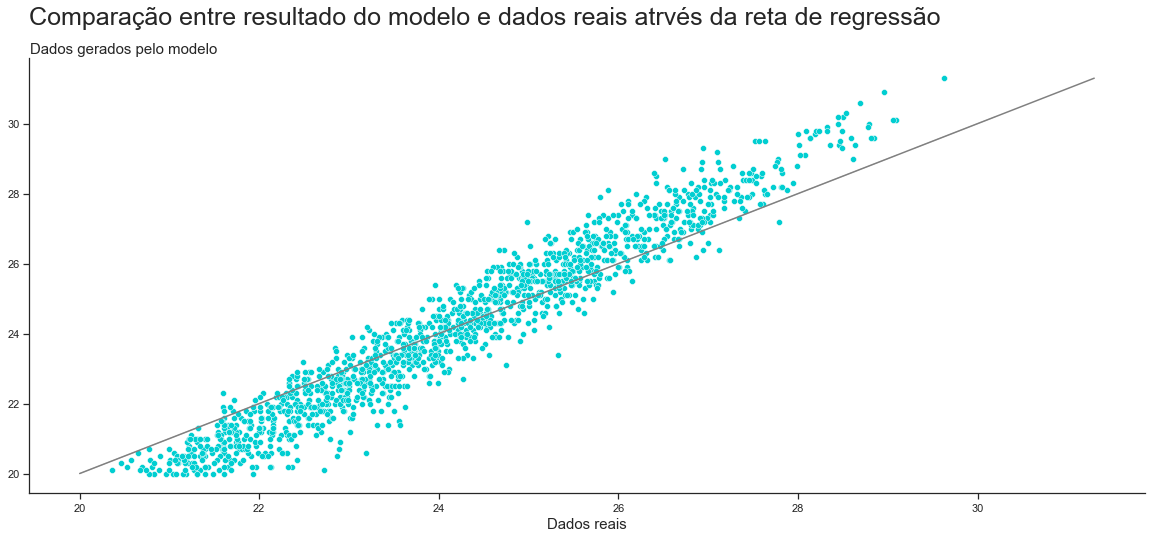

In [30]:
y_previsto_train = modelo_rf.predict(X_train)

sns.set_style('ticks')
plt.figure(figsize = (20, 8))
palette = ['darkturquoise','grey']
grafico = sns.lineplot(x = y_train, y = y_train, color = palette[1])
grafico = sns.scatterplot(x = y_previsto_train, y = y_train, color = palette[0])
grafico.set_title('Comparação entre resultado do modelo e dados reais atrvés da reta de regressão',
                  fontsize = 25, pad= 34, loc = 'left')
grafico.set_xlabel("Dados reais", fontsize = 15)
grafico.set_ylabel("")
grafico.text(x = 19.45, y = 32, s = "Dados gerados pelo modelo", fontsize = 15)
sns.despine()

In [31]:
resultados_modelo = pd.DataFrame(y_previsto_train, columns=["previsao"])
resultados_modelo["real"] = y_train
resultados_modelo.dropna(inplace=True)

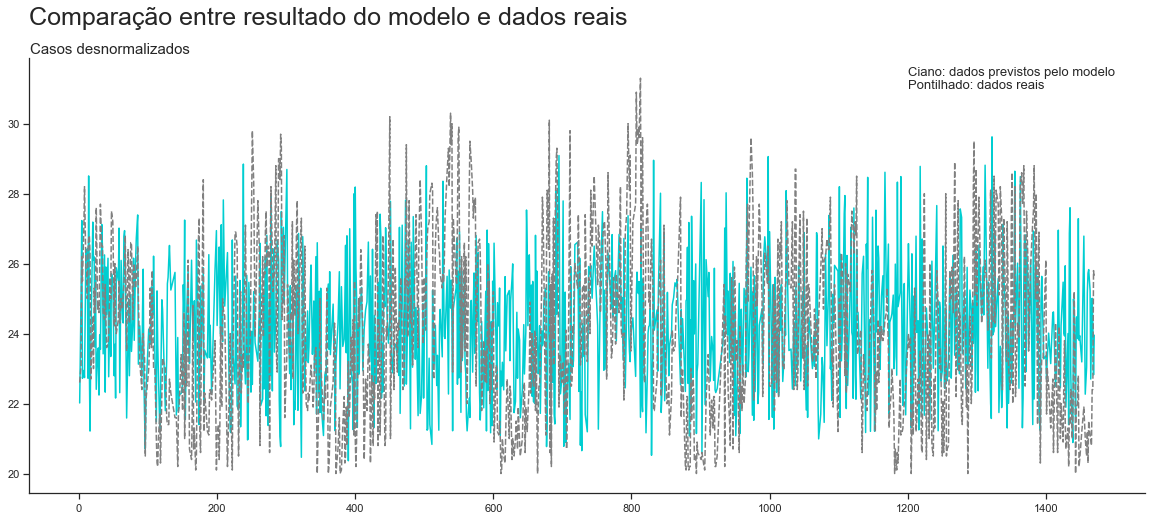

In [32]:
sns.set_style('ticks')
plt.figure(figsize = (20, 8))
palette = ['darkturquoise','grey']
grafico = sns.lineplot(data = resultados_modelo, palette = palette)
grafico.set_title('Comparação entre resultado do modelo e dados reais', fontsize = 25, pad= 34, loc = 'left')
grafico.text(x = 1200, y = 31, s ='Ciano: dados previstos pelo modelo\nPontilhado: dados reais', fontsize = 13)
grafico.text(x = -71, y = 32, s = 'Casos desnormalizados', fontsize = 15)
grafico.get_legend().remove()
sns.despine()

## Teste com dados normalizados

In [33]:
dados_normalizados = dados_poluentes[['co_ppb', 'no2_ppb', 'o3_ppb', 'pm25_ugm3', 'so2_ugm3', 'temperatura_c']]

In [34]:
transformer = Normalizer().fit(dados_normalizados)
dados_normalizados = transformer.transform(dados_normalizados)

In [35]:
dados_normalizados = pd.DataFrame(columns = ['co_ppb', 'no2_ppb', 'o3_ppb',
                                             'pm25_ugm3', 'so2_ugm3', 'temperatura_c'], data=dados_normalizados)

In [36]:
dados_normalizados.head()

,co_ppb,no2_ppb,o3_ppb,pm25_ugm3,so2_ugm3,temperatura_c
0,0.967137,0.013321,0.088810,0.066607,0.007105,0.228241
1,0.970893,0.008715,0.115043,0.072338,0.005229,0.196967
2,0.981833,0.009163,0.057091,0.070483,0.004934,0.166341
3,0.977430,0.006960,0.098207,0.054903,0.003866,0.178628
4,0.984647,0.008859,0.037968,0.037968,0.004430,0.165795


### Dados de treino e teste

In [37]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(dados_normalizados, target = "temperatura_c",
                                                          train_size = 0.7, valid_size = 0.1,
                                                            test_size = 0.2, random_state = 101)

### Resultados classificador inocente

In [38]:
classificador_dummy = DummyRegressor(strategy = 'mean')
classificador_dummy.fit(X_train, y_train)
print(f"Score - Dummy: {(classificador_dummy.score(X_test, y_test))*100:.2f}%")

Score - Dummy: -0.03%


### Modelo RandomForest Regressor

In [39]:
modelo_rf = RandomForestRegressor(n_estimators=100, random_state = SEED)
modelo_rf.fit(X_train, y_train)

previsoes = modelo_rf.predict(X_test)

print(f"Score: {(modelo_rf.score(X_test, y_test))*100:.2f}%")
print(f'RMSE = {np.sqrt(mean_squared_error(y_test, previsoes))}')
print(f'MSE = {(mean_squared_error(y_test, previsoes))}')

Score: 98.07%
RMSE = 0.006372131925076718
MSE = 4.0604065270581914e-05


### Resultados do modelo

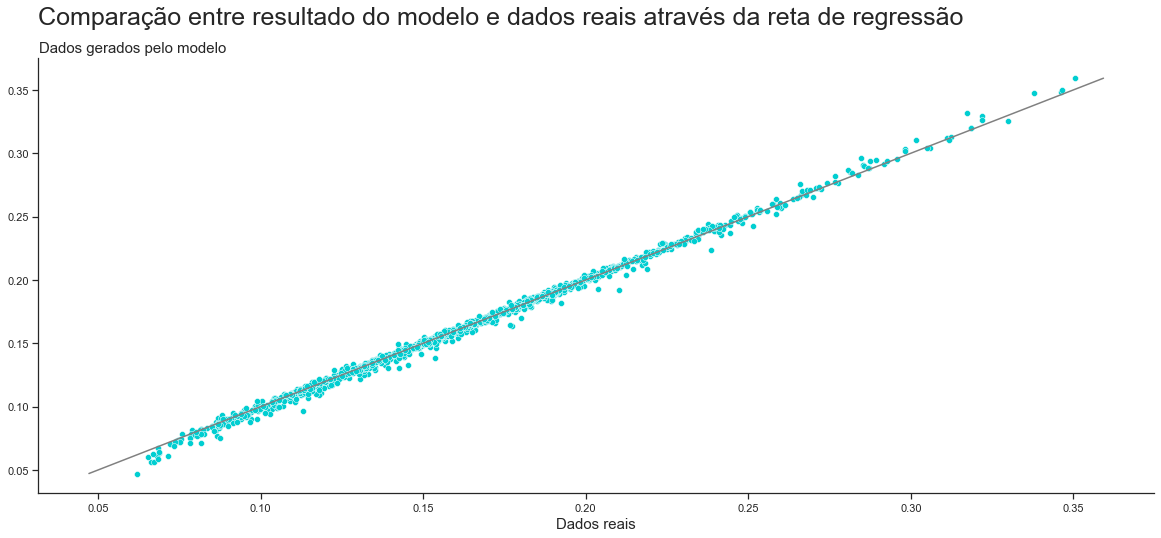

In [40]:
y_previsto_train = modelo_rf.predict(X_train)

sns.set_style('ticks')
plt.figure(figsize = (20, 8))
palette = ['darkturquoise','grey']
grafico = sns.lineplot(x = y_train, y = y_train, color = palette[1])
grafico = sns.scatterplot(x = y_previsto_train, y = y_train, color = palette[0])
grafico.set_title('Comparação entre resultado do modelo e dados reais através da reta de regressão',
                   fontsize = 25, pad= 34, loc = 'left')
grafico.set_xlabel("Dados reais", fontsize = 15)
grafico.set_ylabel("")
grafico.text(x = 0.032, y = 0.38, s = "Dados gerados pelo modelo", fontsize = 15)
sns.despine()

In [41]:
resultados_modelo = pd.DataFrame(y_previsto_train, columns=["previsao"])
resultados_modelo["real"] = y_train
resultados_modelo.dropna(inplace=True)

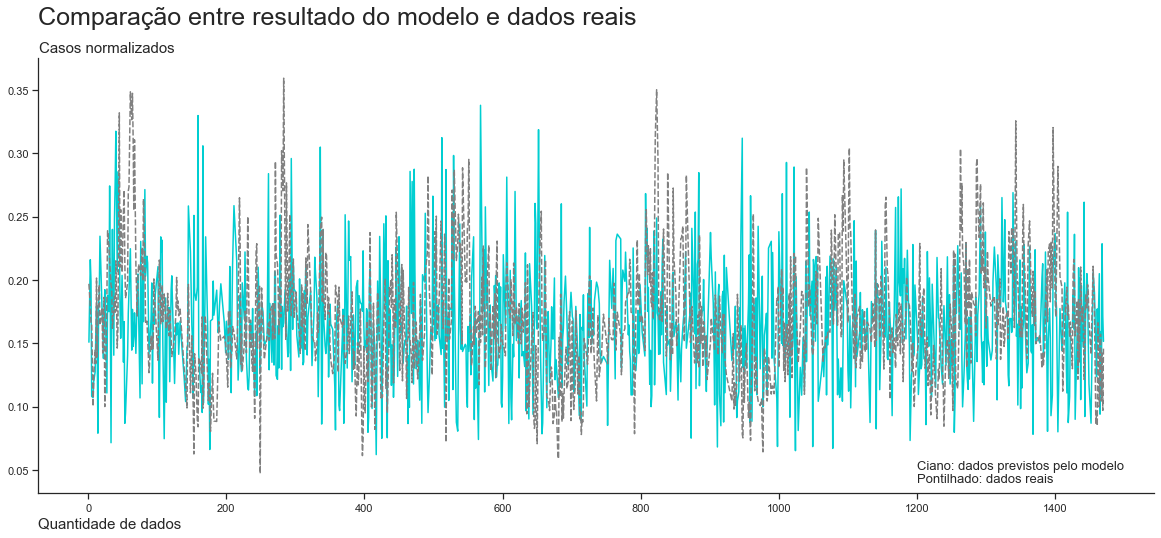

In [42]:
sns.set_style('ticks')
plt.figure(figsize = (20, 8))
palette = ['darkturquoise','grey']
grafico = sns.lineplot(data = resultados_modelo, palette = palette)
grafico.set_title('Comparação entre resultado do modelo e dados reais', fontsize = 25, pad= 34, loc = 'left')
grafico.set_xlabel('Quantidade de dados', fontsize = 15, loc = "left")
grafico.text(x = 1200, y = 0.04, s ='Ciano: dados previstos pelo modelo\nPontilhado: dados reais', fontsize = 13)
grafico.text(x = -71, y = 0.38, s = 'Casos normalizados', fontsize = 15)
grafico.get_legend().remove()
sns.despine()

# Testes com dados normalizados e desnormalizados com GridSearchCV e RandomizedSearchCV


In [43]:
espaco_de_parametros1 = {
    'max_depth' : [5, 10, 15, 20],
    'min_samples_leaf': [5,7,10,12,13],
    "min_samples_split": [40],
    "n_estimators": [100]
}

espaco_de_parametros2 = {
    "n_estimators" : [10, 20, 30],
    "max_depth" : [3, 5, 7],
    "bootstrap" : [True, False],
    "criterion": ["squared_error", "absolute_error", "poisson"]
}

X_train_norm, y_train_norm, X_valid_norm, y_valid_norm, X_test_norm, y_test_norm = train_valid_test_split(
                                                            dados_normalizados, target = "temperatura_c",
                                                            train_size = 0.7, valid_size = 0.1,
                                                            test_size = 0.2, random_state = 101)

### GridSearchCV

#### Espaço 1 - dados normalizados

In [44]:
busca = GridSearchCV(RandomForestRegressor(),
                    espaco_de_parametros1,
                    cv = 5)

busca.fit(X_train_norm, y_train_norm)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.435708,0.036416,0.023601,0.001200,5,5,40,100,"{'max_depth': 5, 'min_samples_leaf': 5, 'min_s...",0.898618,0.904582,0.905664,0.909766,0.908632,0.905452,0.003905,17
1,0.503582,0.063187,0.024385,0.001362,5,7,40,100,"{'max_depth': 5, 'min_samples_leaf': 7, 'min_s...",0.904407,0.904466,0.908733,0.910634,0.907037,0.907055,0.002423,16
2,0.448859,0.038288,0.028200,0.006390,5,10,40,100,"{'max_depth': 5, 'min_samples_leaf': 10, 'min_...",0.899346,0.903963,0.903537,0.911643,0.904928,0.904683,0.003970,19
3,0.430113,0.046301,0.022399,0.000489,5,12,40,100,"{'max_depth': 5, 'min_samples_leaf': 12, 'min_...",0.895849,0.903008,0.907659,0.910307,0.907783,0.904921,0.005112,18
4,0.412773,0.005426,0.023391,0.001014,5,13,40,100,"{'max_depth': 5, 'min_samples_leaf': 13, 'min_...",0.895146,0.900052,0.905346,0.910090,0.905512,0.903229,0.005142,20


In [45]:
busca.best_score_

0.9204439128627893

#### Espaço 2 - dados normalizados

In [46]:
busca = GridSearchCV(RandomForestRegressor(),
                    espaco_de_parametros2,
                    cv = 5)

busca.fit(X_train_norm, y_train_norm)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.039419,0.002717,0.005201,4.004732e-04,True,squared_error,3,10,"{'bootstrap': True, 'criterion': 'squared_erro...",0.790077,0.777095,0.764020,0.815208,0.776966,0.784673,0.017349,44
1,0.076870,0.005900,0.006201,3.124591e-03,True,squared_error,3,20,"{'bootstrap': True, 'criterion': 'squared_erro...",0.791939,0.790162,0.767697,0.815391,0.774878,0.788013,0.016461,40
2,0.114240,0.017717,0.008600,4.902529e-04,True,squared_error,3,30,"{'bootstrap': True, 'criterion': 'squared_erro...",0.794909,0.790807,0.772364,0.812579,0.774921,0.789116,0.014622,39
3,0.044590,0.000485,0.005002,5.309834e-07,True,squared_error,5,10,"{'bootstrap': True, 'criterion': 'squared_erro...",0.920923,0.926575,0.918786,0.925720,0.909287,0.920258,0.006208,17
4,0.086244,0.000672,0.007410,4.832793e-04,True,squared_error,5,20,"{'bootstrap': True, 'criterion': 'squared_erro...",0.931743,0.923351,0.921222,0.933231,0.918414,0.925592,0.005862,13


In [47]:
busca.best_score_

0.9620304395425467

In [48]:
busca.best_estimator_

RandomForestRegressor(max_depth=7, n_estimators=30)

### RandomizedSearchCV

#### Espaço 1 - dados normalizados

In [49]:
busca = RandomizedSearchCV(RandomForestRegressor(),
                   espaco_de_parametros1,
                    n_iter = 20,
                    cv = 5)

busca.fit(X_train_norm, y_train_norm)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.039387,0.208008,0.041204,0.014291,100,40,5,5,"{'n_estimators': 100, 'min_samples_split': 40,...",0.900135,0.901571,0.906153,0.912136,0.902536,0.904506,0.004302,20
1,1.323663,0.483946,0.059802,0.058191,100,40,7,5,"{'n_estimators': 100, 'min_samples_split': 40,...",0.900252,0.902064,0.907590,0.908676,0.906370,0.904991,0.003264,18
2,0.627939,0.108085,0.033404,0.008429,100,40,10,5,"{'n_estimators': 100, 'min_samples_split': 40,...",0.899851,0.903075,0.909119,0.909030,0.906544,0.905524,0.003590,16
3,0.501888,0.088029,0.028993,0.012510,100,40,12,5,"{'n_estimators': 100, 'min_samples_split': 40,...",0.896766,0.901107,0.909680,0.910482,0.905859,0.904779,0.005204,19
4,0.717735,0.146833,0.039436,0.012317,100,40,13,5,"{'n_estimators': 100, 'min_samples_split': 40,...",0.896999,0.902114,0.908191,0.910949,0.908120,0.905275,0.005045,17


In [50]:
busca.best_score_

0.9206872767274452

#### Espaço 2 - dados normalizados

In [51]:
busca = RandomizedSearchCV(RandomForestRegressor(),
                    espaco_de_parametros2,
                    n_iter = 20,
                    cv = 5)

busca.fit(X_train_norm, y_train_norm)
resultados = pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.349134,0.497573,0.007801,0.001471,10,5,absolute_error,False,"{'n_estimators': 10, 'max_depth': 5, 'criterio...",0.883384,0.864311,0.841997,0.877955,0.842383,0.862006,0.017333,15
1,2.252553,0.302491,0.008801,0.000399,20,7,absolute_error,False,"{'n_estimators': 20, 'max_depth': 7, 'criterio...",0.930883,0.908562,0.897719,0.920732,0.897871,0.911153,0.012997,10
2,3.650507,0.780057,0.011400,0.001743,20,5,absolute_error,False,"{'n_estimators': 20, 'max_depth': 5, 'criterio...",0.883384,0.864311,0.841997,0.877955,0.842383,0.862006,0.017333,15
3,1.630782,0.446696,0.022401,0.010053,30,3,absolute_error,True,"{'n_estimators': 30, 'max_depth': 3, 'criterio...",0.784247,0.802925,0.769974,0.808516,0.771137,0.787360,0.015906,18
4,0.323756,0.173439,0.047706,0.074913,20,5,poisson,True,"{'n_estimators': 20, 'max_depth': 5, 'criterio...",0.923829,0.924360,0.921559,0.923198,0.918076,0.922204,0.002269,6


In [52]:
busca.best_score_

0.9622811693292169

In [53]:
busca.best_estimator_

RandomForestRegressor(criterion='poisson', max_depth=7, n_estimators=30)

## Resultados com busca

Os resultados com métodos de busca não obtiveram um grande ganho de score, logo, não serão implementados modelos de ML com base nos estimadores gerados pela busca. Ambas as buscas foram melhor com o segundo espaço de parâmetros.

## Validação do modelo Random Forest Original

In [54]:
def imprime_resultados(resultados):
    media = resultados['test_score'].mean()
    desvio_padrao = resultados['test_score'].std()
    print(f"Acurácia: {media * 100:.2f}")
    print(f"Acurácia: [{(media - 2 * desvio_padrao)*100:.2f}, {(media + 2 * desvio_padrao)*100:.2f}]")

In [55]:
modelo_rf = RandomForestRegressor(n_estimators=100, random_state = SEED)
modelo_rf.fit(X_train_norm, y_train_norm)

previsoes = modelo_rf.predict(X_test_norm)

print(f"Score: {(modelo_rf.score(X_test_norm, y_test_norm))*100:.2f}%")
print(f'RMSE = {np.sqrt(mean_squared_error(y_test_norm, previsoes))}')
print(f'MSE = {(mean_squared_error(y_test_norm, previsoes))}')

Score: 98.07%
RMSE = 0.006372131925076718
MSE = 4.0604065270581914e-05


In [56]:
resultados = cross_validate(modelo_rf, X_valid_norm, y_valid_norm, cv = 10, return_train_score=False)
imprime_resultados(resultados)

Acurácia: 85.41
Acurácia: [62.04, 108.78]


## Validação do modelo Random Forest - GridSearchCV

In [57]:
modelo_rf = RandomForestRegressor(max_depth=7, n_estimators=30, random_state = SEED)
modelo_rf.fit(X_train_norm, y_train_norm)

previsoes = modelo_rf.predict(X_test_norm)

print(f"Score: {(modelo_rf.score(X_test_norm, y_test_norm))*100:.2f}%")
print(f'RMSE = {np.sqrt(mean_squared_error(y_test_norm, previsoes))}')

Score: 96.51%
RMSE = 0.008574765800455865


In [58]:
resultados = cross_validate(modelo_rf, X_valid_norm, y_valid_norm, cv = 10, return_train_score=False)
imprime_resultados(resultados)

Acurácia: 85.60
Acurácia: [63.36, 107.84]


Os resultados com o modelo treinado com o estimador gerado do melhor resultado da busca obteve um melhor desempenho comparado ao modelo original e ao gerado pelo RandomizedSearchCV, embora o seu score tenha sido menor.

## Validação do modelo Random Forest - RandomizedSearchCV

In [59]:
modelo_rf = RandomForestRegressor(criterion='poisson', max_depth=7, n_estimators=30, random_state = SEED)
modelo_rf.fit(X_train_norm, y_train_norm)

previsoes = modelo_rf.predict(X_test_norm)

print(f"Score: {(modelo_rf.score(X_test_norm, y_test_norm))*100:.2f}%")
print(f'RMSE = {np.sqrt(mean_squared_error(y_test_norm, previsoes))}')

Score: 96.50%
RMSE = 0.008594435421317333


In [60]:
resultados = cross_validate(modelo_rf, X_valid_norm, y_valid_norm, cv = 10, return_train_score=False)
imprime_resultados(resultados)

Acurácia: 85.25
Acurácia: [62.03, 108.48]


Os resultados com o modelo treinado com o estimador gerado do melhor resultado da busca aleatória obteve um desempenho menor comparado ao modelo original e ao GridSearchCV.